# Train model using the fastai library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import packages

In [101]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import scipy.io.wavfile
import torch
from fastai.vision import *
from fastai.metrics import error_rate

## Instantiate ImageDataBunch

In [3]:
pat = r'/(\w+)_\d+.jpg'

In [114]:
path_img = "../mfc_dataset"
fnames = sorted(get_image_files(path_img))
np.random.seed(42)
np.random.shuffle(fnames)
fnames[:5]

[PosixPath('../mfc_dataset/female_3075.jpg'),
 PosixPath('../mfc_dataset/male_3161.jpg'),
 PosixPath('../mfc_dataset/male_4055.jpg'),
 PosixPath('../mfc_dataset/male_5550.jpg'),
 PosixPath('../mfc_dataset/female_3396.jpg')]

In [104]:
data = ImageDataBunch.from_name_re(
    path_img, fnames, pat, size=224, bs=64, valid_pct=0.2, seed=42
).normalize(imagenet_stats)

For more information on batch size selection, see https://forums.fast.ai/t/how-to-check-your-pytorch-keras-is-using-the-gpu/7232/3.

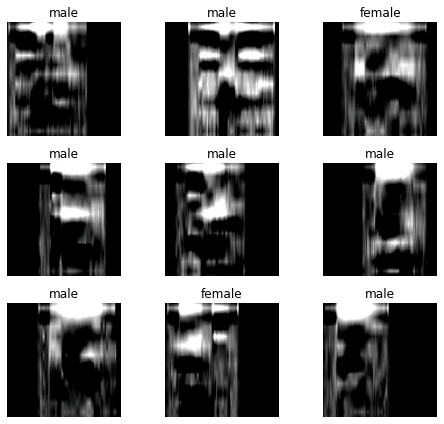

In [105]:
data.show_batch(rows=3, figsize=(7,6))

In [97]:
print(data.classes)
len(data.classes),data.c

['female', 'male']


(2, 2)

## Train ResNet34

### Transfer learning step 1: Only retrain the classifier

Instantiate a learner using data, model and metric:

In [55]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Verify the availability of GPU(s):

In [21]:
torch.cuda.is_available()

True

Find a good learning rate: (https://docs.fast.ai/callbacks.lr_finder.html)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


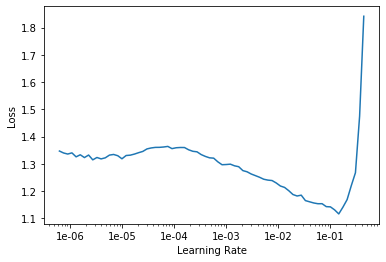

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(5, 2e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.389088,0.238326,0.093333,03:00
1,0.135389,0.103017,0.038333,02:59
2,0.076351,0.061760,0.020833,02:59
3,0.034841,0.039833,0.013500,02:59
4,0.018409,0.030908,0.011500,02:59


Our model is pretty accurate!

### Transfer learning step 2: Retrain the entire model

After retraining the classifier, let's also train the convolutional layers.

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.089817,0.072006,0.026833,04:17
1,0.011483,0.010009,0.003000,04:17


<div style="text-align: justify">
In the context of this dataset, unfreezing and retraining the entire model sometimes do not increase its performance - but sometimes it do. For this reason, I left it untouched. Good luck for you!
</div>

In [27]:
learn.export()

## Evaluate model

### Identify outliers

In [122]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model = load_learner(path_img).model
# ClassificationInterpretation.from_learner requires the learn to has validation data.
# However, load_learner(path_img) does not have validation data.
# Therefore, I had to use the workaround above.

In [107]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

In [108]:
losses, idxs = interp.top_losses()  # only uses data from the validation set

<div style="text-align: justify">
The outliers displayed as MFCs and the Grad-CAM heatmaps are not intuitive because we humans can't read off sounds from MFCs:
</div>

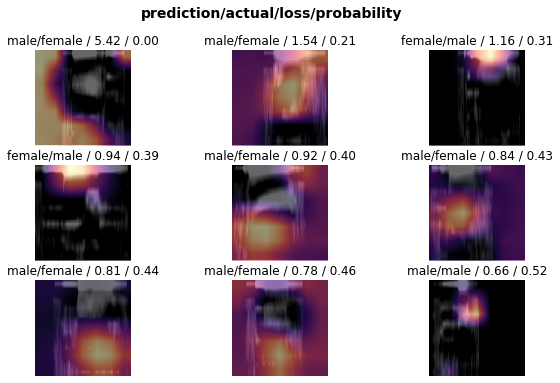

In [109]:
interp.plot_top_losses(9, figsize=(10, 6), heatmap=True)

Instead, let's try hearing the top losses: (https://forums.fast.ai/t/how-to-get-data-val-ds-fnames-in-fastai-v1-0/37231)

In [121]:
data.x.items[idxs][:5]

array([PosixPath('../mfc_dataset/female_3522.jpg'), PosixPath('../mfc_dataset/male_11096.jpg'),
       PosixPath('../mfc_dataset/male_4698.jpg'), PosixPath('../mfc_dataset/male_14164.jpg'),
       PosixPath('../mfc_dataset/female_1333.jpg')], dtype=object)

The confusion matrix and the F1 score are commonly used to evaluate classifiers:

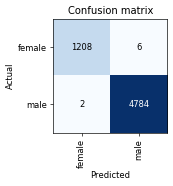

In [111]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

F1 score: (Since this is a binary classification task, we can think of "female" as "true" and "male as "false".)

In [112]:
cmat = interp.confusion_matrix()
precision = cmat[0][0] / (cmat[0][0] + cmat[1][0])  # true positives / (true positives + false positives = positive predictions) 
recall = cmat[0][0] / (cmat[0][0] + cmat[0][1])  # true positives / (true positives + false negatives = positive ground truths)
f1_score = 2 / (1 / precision + 1 / recall)

In [113]:
f1_score

0.9966996699669968

## Mean Grad-CAM for male MFCs and female MFCs